<a href="https://colab.research.google.com/github/muratal49/NLP/blob/main/HW3_BERT_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning BERT for Natural Language Inference



## 1. Introduction
In this notebook, we will build a deep learning model to perform Natural Language Inference (NLI) task. NLI is classifying relationships between pairs of sentences to *contradication*, *entailment* or *neutral*.
Dataset used for this task is training, validation and test sets from [Stanford Natural Language Inference (SNLI) Corpus](https://nlp.stanford.edu/projects/snli/). You can check the [dataset](https://huggingface.co/datasets/stanfordnlp/snli) from the hugging face. Please note that all required code implementations are marked with "TODO".

In [ ]:
import torch
import random


random.seed(1366)



make sure find a GPU device

In [ ]:
# Check for GPU availability
if not torch.cuda.is_available():
    raise SystemError("GPU device not found")
print(f"Found GPU at: {torch.cuda.get_device_name(0)}")





Found GPU at: Tesla T4


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

install datasets library to load SNLI dataset from hugging face

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

Download SNLI dataset, we only use 5% training data, 20% validation and test data to save training and inference cost.

In [ ]:
from datasets import load_dataset


full_datasets = {
    "train": load_dataset("snli", split="train[:5%]"),
    "validation": load_dataset("snli", split="validation[:20%]"),
    "test": load_dataset("snli", split="test[:20%]")
}

print(f"Train size: {len(full_datasets['train'])}, Validation size: {len(full_datasets['validation'])}, Test size: {len(full_datasets['test'])}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Train size: 27508, Validation size: 2000, Test size: 2000


The structure of the `full_datasets` object and some examples from the dataset. Each data sample contains a premise, a hypothesis, and a label.

In [ ]:
type(full_datasets)

dict

In [ ]:
full_datasets

{'train': Dataset({
     features: ['premise', 'hypothesis', 'label'],
     num_rows: 27508
 }),
 'validation': Dataset({
     features: ['premise', 'hypothesis', 'label'],
     num_rows: 2000
 }),
 'test': Dataset({
     features: ['premise', 'hypothesis', 'label'],
     num_rows: 2000
 })}

In [ ]:
full_datasets["train"][:3]

{'premise': ['A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.'],
 'hypothesis': ['A person is training his horse for a competition.',
  'A person is at a diner, ordering an omelette.',
  'A person is outdoors, on a horse.'],
 'label': [1, 2, 0]}

## 2. Exploring the Data
At this stage, we are going to take a look at 5 random examples of each of the contradication, entailment and neutral relationships to grasp a more concrete idea of what they mean.

In [ ]:
import random

def sentence_sampler(dataset, category, n=5):
    """
    Prints a sample of premise-hypothesis pairs with a certain label.

    INPUTS:
        dataset (Dataset): The dataset (e.g., full_datasets["train"])
        category : Label (0=entailment, 1=neutral, 2=contradiction)
        n (int): Number of samples to print
    """
    samples = random.sample([x for x in dataset if x['label'] == category], n)
    # TODO: sample n examples with the specified category from the dataset and print them
    # Hint: you can use random.sample to sample n examples from a list
    for sample in samples:
        print(f"Premise: {sample['premise']}")
        print(f"Hypothesis: {sample['hypothesis']}")
        print("-" * 80)

    print("\n" + "=" * 100 + "\n")  # Separator for readability

    return

In [ ]:

# category mapping: 0=entailment, 1=neutral, 2=contradiction
print("EXAMPLES OF ENTAILMENT (0):\n")
sentence_sampler(full_datasets["train"], 0)

print("EXAMPLES OF NEUTRAL (1):\n")
sentence_sampler(full_datasets["train"], 1)

print("EXAMPLES OF CONTRADICTION (2):\n")
sentence_sampler(full_datasets["train"], 2)


EXAMPLES OF ENTAILMENT (0):

Premise: A person wearing a striped skirt and head covering is walking with a bowl on her head while a child follows behind.
Hypothesis: A person has a bowl on their head.
--------------------------------------------------------------------------------
Premise: An old man on a bicycle riding along a wooded country road with sun filtering through the treetops.
Hypothesis: An old man is riding a bike.
--------------------------------------------------------------------------------
Premise: A worker in a yellow coat pushes a cart.
Hypothesis: An employee is pushing a cart.
--------------------------------------------------------------------------------
Premise: A guy riding a skateboard in front of a graffiti wall.
Hypothesis: A man is outside riding his skateboard
--------------------------------------------------------------------------------
Premise: An elder man conducting an orchestra.
Hypothesis: A person conducts an orchestra.
--------------------------

Some examples do not have valid label (labeled as -1) in the dataset. We remove these examples.

In [ ]:
from collections import Counter

In [ ]:
full_datasets["train"].filter(lambda x: x["label"] == -1)

Filter:   0%|          | 0/27508 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 36
})

In [ ]:
from collections import Counter

def count_labels(dataset):
    """
    Counts the number of occurrences of each label in the dataset.

    INPUT:
        dataset (Dataset): The dataset (e.g., full_datasets["train"])

    OUTPUT:
        Prints label distribution.
    """

    # TODO: count the number of occurrences of each label in the dataset and print the counts
    # Hint: you can use a Counter object to count occurrences of each label
    label_counts=Counter(dataset['label'])
    for i,j in label_counts.items():
        print(i,j)
    return

In [ ]:
print("Train Set:")
count_labels(full_datasets["train"])

print("\nValidation Set:")
count_labels(full_datasets["validation"])

print("\nTest Set:")
count_labels(full_datasets["test"])


Train Set:
1 9145
2 9151
0 9176
-1 36

Validation Set:
1 668
0 648
2 648
-1 36

Test Set:
1 649
0 678
2 639
-1 34


In [ ]:
def remove_invalid_labels(dataset):
  """
  Removes examples where label is -1 (invalid examples).

  INPUT:
      dataset (Dataset): The dataset to clean (e.g., full_datasets["train"])

  OUTPUT:
      Cleaned dataset without -1 labels.
  """
  # TODO: remove examples where label is -1 (invalid examples)
  # Hint: you can use dataset.filter to filter out examples with label -1
  dataset = dataset.filter(lambda x: x["label"] != -1)
  return dataset


full_datasets["train"] = remove_invalid_labels(full_datasets["train"])
full_datasets["validation"] = remove_invalid_labels(full_datasets["validation"])
full_datasets["test"] = remove_invalid_labels(full_datasets["test"])


print("Train Set:")
count_labels(full_datasets["train"])

print("\nValidation Set:")
count_labels(full_datasets["validation"])

print("\nTest Set:")
count_labels(full_datasets["test"])


Filter:   0%|          | 0/27508 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train Set:
1 9145
2 9151
0 9176

Validation Set:
1 668
0 648
2 648

Test Set:
1 649
0 678
2 639


### 2.1 Validation and Test Set Distributions
Before building models and iterating over them to improve performance,it is necessay to make sure that validation and test data sets come from the same distribution. We do this investigation from two view points:
* Are the distributions of sentence lengths similar in both data sets?
* Are the vacabularies of the words used in both data sets similiar?

In [ ]:
import matplotlib.pyplot as plt

# Add sentence lengths
def add_sentence_lengths(example):
  example["premise_len"] = len(example["premise"])
  example["hypothesis_len"] = len(example["hypothesis"])
  example["premise - hypothesis"] = example["premise_len"] - example["hypothesis_len"]
  return example

# Apply function to validation and test sets
full_datasets["validation"] = full_datasets["validation"].map(add_sentence_lengths)
full_datasets["test"] = full_datasets["test"].map(add_sentence_lengths)


Map:   0%|          | 0/1964 [00:00<?, ? examples/s]

Map:   0%|          | 0/1966 [00:00<?, ? examples/s]

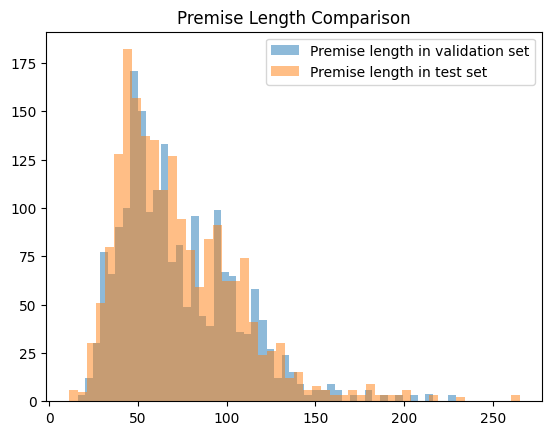

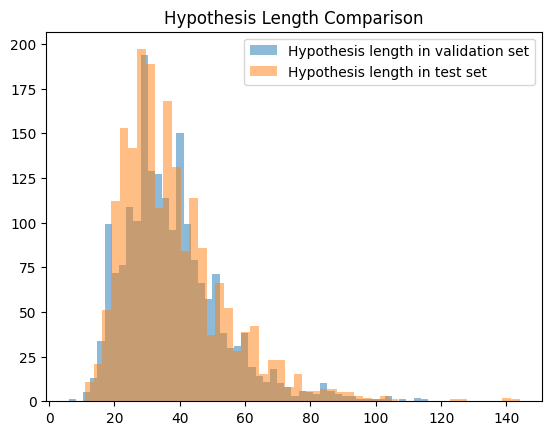

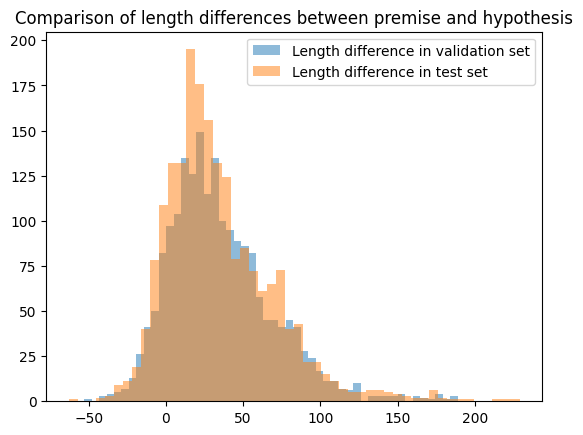

In [ ]:
# Extract data
val_premise_len = full_datasets["validation"]["premise_len"]
test_premise_len = full_datasets["test"]["premise_len"]
val_hypothesis_len = full_datasets["validation"]["hypothesis_len"]
test_hypothesis_len = full_datasets["test"]["hypothesis_len"]
val_len_diff = full_datasets["validation"]["premise - hypothesis"]
test_len_diff = full_datasets["test"]["premise - hypothesis"]

# Plot premise length histogram
plt.hist(val_premise_len, bins=50, label="Premise length in validation set", alpha=0.5)
plt.hist(test_premise_len, bins=50, label="Premise length in test set", alpha=0.5)
plt.title("Premise Length Comparison")
plt.legend(loc='best')
plt.show()

# Plot hypothesis length histogram
plt.hist(val_hypothesis_len, bins=50, label="Hypothesis length in validation set", alpha=0.5)
plt.hist(test_hypothesis_len, bins=50, label="Hypothesis length in test set", alpha=0.5)
plt.title("Hypothesis Length Comparison")
plt.legend(loc='best')
plt.show()

# Plot length difference histogram
plt.hist(val_len_diff, bins=50, label="Length difference in validation set", alpha=0.5)
plt.hist(test_len_diff, bins=50, label="Length difference in test set", alpha=0.5)
plt.title("Comparison of length differences between premise and hypothesis")
plt.legend(loc='best')
plt.show()


It is evident that validation and test sets are similiar length-wise. Then, Let's go into the vocabulary used in each data set.

In [ ]:
full_datasets["validation"]['premise'][0].split()

['Two',
 'women',
 'are',
 'embracing',
 'while',
 'holding',
 'to',
 'go',
 'packages.']

In [ ]:
import string

def unique_words_extractor(example):
  """
  Extracts unique words from premise and hypothesis.

  INPUT:
      example (dict): A row from the dataset (premise/hypothesis)

  OUTPUT:
      Dictionary with extracted words ({premise_words: [], hypothesis_words: []}).
  """
    # TODO: extract unique words from premise and hypothesis

  example["premise_words"] = list(set([word.strip(string.punctuation) for word in example["premise"].split()]))
  example["hypothesis_words"] = list(set([word.strip(string.punctuation) for word in example["hypothesis"].split()]))

  return example
# Apply function to validation and test sets
full_datasets["validation"] = full_datasets["validation"].map(unique_words_extractor)
full_datasets["test"] = full_datasets["test"].map(unique_words_extractor)

# Extract all words
val_vocab = set(sum(full_datasets["validation"]["premise_words"], []) + sum(full_datasets["validation"]["hypothesis_words"], []))
test_vocab = set(sum(full_datasets["test"]["premise_words"], []) + sum(full_datasets["test"]["hypothesis_words"], []))


Map:   0%|          | 0/1964 [00:00<?, ? examples/s]

Map:   0%|          | 0/1966 [00:00<?, ? examples/s]

In [ ]:
def common_words_finder(vocab1, vocab2):
    """
    Finds common words between two sets.

    INPUTS:
        vocab1 (set): First set of words
        vocab2 (set): Second set of words

    OUTPUTS:
        set: Intersection of words between two sets
    """

    # TODO: find common words between vocab1 and vocab2
    common_vocab = vocab1.intersection(vocab2)
    return  common_vocab

# Compute common words
common_vocab = common_words_finder(val_vocab, test_vocab)


In [ ]:
print("Number of unique words in validation set:", len(val_vocab))
print("Number of unique words in test set:", len(test_vocab))
print("Number of unique common words in validation and test set:", len(common_vocab))
print("Percentage of common words in test set:", len(common_vocab) / len(test_vocab))

Number of unique words in validation set: 2846
Number of unique words in test set: 3012
Number of unique common words in validation and test set: 1542
Percentage of common words in test set: 0.5119521912350598


What is your observation here? How many words in the test set are unseen during validation?



> **OBSERVATION**: Looks like *little less than half of the words* in the test set are not seen during validation. That is around 1500 words.



## 3. Building the model
We will use pretrained uncased english BERT as the core encoder (word embedder) of our model architecture.
### 3.1 Preprocess step: Preparing inputs of the BERT encoder


Here we define a BERT tokenizer instance.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Below, we define `preprocess_examples` function for pre-processing data.

In [ ]:
max_length = 128

def preprocess_examples(examples):
  """
  Tokenizes premise and hypothesis.

  INPUT:
      examples (dict): SNLI examples

  OUTPUT:
      tokenized_inputs (dict): Tokenized sentences with labels
  """
  # TODO: tokenize premise and hypothesis keeping the labels:
  tokenized_inputs = tokenizer(examples["premise"], examples["hypothesis"], truncation=True, padding="max_length", max_length=max_length)
  tokenized_inputs["labels"] = examples["label"]
  return tokenized_inputs


Then we use `preprocess_examples` functions to convert the raw dataset to a tokenized dataset.

In [ ]:
from datasets import Dataset


tokenized_datasets = {
    "train": full_datasets["train"].map(preprocess_examples, batched=True, remove_columns=full_datasets["train"].column_names),
    "validation": full_datasets["validation"].map(preprocess_examples, batched=True, remove_columns=full_datasets["validation"].column_names),
    "test": full_datasets["test"].map(preprocess_examples, batched=True, remove_columns=full_datasets["test"].column_names),
}


print(tokenized_datasets["train"][:2])


Map:   0%|          | 0/27472 [00:00<?, ? examples/s]

Map:   0%|          | 0/1964 [00:00<?, ? examples/s]

Map:   0%|          | 0/1966 [00:00<?, ? examples/s]

{'input_ids': [[101, 1037, 2711, 2006, 1037, 3586, 14523, 2058, 1037, 3714, 2091, 13297, 1012, 102, 1037, 2711, 2003, 2731, 2010, 3586, 2005, 1037, 2971, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1037, 2711, 2006, 1037, 3586, 14523, 2058, 1037, 3714, 2091, 13297, 1012, 102, 1037, 2711, 2003, 2012, 1037, 15736, 1010, 13063, 2019, 18168, 12260, 4674, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

The structure of the `tokenized_datasets` object:

In [ ]:
tokenized_datasets

{'train': Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 27472
 }),
 'validation': Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1964
 }),
 'test': Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1966
 })}

In [ ]:
# full_datasets['validation']['hypothesis'][:5]

In [ ]:
# # tokenized_datasets["validation"]['input_ids'][:2]
# tokenizer.decode(tokenized_datasets["validation"]['input_ids'][0])

Below we show a training sample for the Natural Language Inference (NLI) task.
We present the premise, hypothesis and label in the first three rows. The tokenized words are in the next row.
To make it interpretable, we convert token IDs back into words.

As you can see, the input_ids contains both premise and hypothesis separated by a [SEP] token.
The last two rows show the token_type_ids, attention_mask for the NLI task.

In [ ]:

sample_index = 0
example = full_datasets["train"][sample_index]


tokenized_example = tokenized_datasets["train"][sample_index]

print("Premise: ", example["premise"])
print("Hypothesis: ", example["hypothesis"])
print("Label: ", example["label"])
print("-" * 50)

print("Tokenized input_ids: ", tokenized_example["input_ids"])
print("Decoded input_ids: ", tokenizer.decode(tokenized_example["input_ids"]))
print("-" * 50)

print("Token type ids: ", tokenized_example["token_type_ids"])  # 0 = Premise, 1 = Hypothesis
print("Attention mask: ", tokenized_example["attention_mask"])


Premise:  A person on a horse jumps over a broken down airplane.
Hypothesis:  A person is training his horse for a competition.
Label:  1
--------------------------------------------------
Tokenized input_ids:  [101, 1037, 2711, 2006, 1037, 3586, 14523, 2058, 1037, 3714, 2091, 13297, 1012, 102, 1037, 2711, 2003, 2731, 2010, 3586, 2005, 1037, 2971, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded input_ids:  [CLS] a person on a horse jumps over a broken down airplane. [SEP] a person is training his horse for a competition. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

We build `dataset` and `dataloader` below once the pre-processing is completed.

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

# Convert datasets to PyTorch format
tokenized_datasets["train"].set_format("torch")
tokenized_datasets["validation"].set_format("torch")
tokenized_datasets["test"].set_format("torch")

# Create DataLoaders
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=32,pin_memory=True
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"],
    collate_fn=default_data_collator,
    batch_size=32,pin_memory=True
)

test_dataloader = DataLoader(
    tokenized_datasets["test"],
    collate_fn=default_data_collator,
    batch_size=32,pin_memory=True
)



In [ ]:
train_dataloader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

#Saving all DataLoaders to drive:
#saving Dataloaders to drive:

# import pickle
# data_path='/content/drive/MyDrive/Colab Notebooks/datafiles'
# with open(data_path+'/BERT_tokenized_train_dataloader.pkl', 'wb') as f:
#     pickle.dump(train_dataloader,f)
#     print("Datafile saved")
# with open(data_path+'/BERT_tokenized_eval_dataloader.pkl', 'wb') as f:
#     pickle.dump(eval_dataloader,f)
#     print("Datafile saved")
# with open(data_path+'/BERT_tokenized_test_dataloader.pkl', 'wb') as f:
#     pickle.dump(test_dataloader,f)
#     print("Datafile saved")


In [ ]:
#getting the dataloader from drive:
# import pickle
# data_path='/content/drive/MyDrive/Colab Notebooks/datafiles'
# with open(data_path+'/BERT_tokenized_train_dataloader.pkl', 'rb') as f:
#     train_dataloader = pickle.load(f)

### 3.2 Metrics
Before we build the BERT model, we should define the performance metric to measure the NLI quality of any given model. Here the compute_metrics function is used for metric calculation, we use accuracy and macro-F1.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    """
    Compute accuracy and macro-F1.

    Parameters:
        eval_pred (tuple): Tuple containing predictions and labels.

    Returns:
        dict: Dictionary containing accuracy and macro-F1 scores. {"accuracy": acc, "macro-F1": f1}
    """
    logits, labels = eval_pred

    # TODO: compute accuracy and macro-F1, and return them in a dictionary
    # Hint: you can use accuracy_score and f1_score from sklearn, you can also implement your own functions
    preds = logits.argmax(-1).cpu().numpy()
    labels = labels.cpu().numpy()
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "macro-F1": f1}



### SAVING TOKENIZED DATA to DRIVE:

### 3.3 Training and Evaluation
Next, we build a BERT model for NLI.

In [ ]:
import torch
from torch import nn
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput

class BertForNLI(BertPreTrainedModel):
  def __init__(self, config,classifier_type="mlp"):
    """
    Custom BERT model for Natural Language Inference (NLI) with MLP classification head.

    Parameters:
        config: Model configuration.
    """
    super().__init__(config)
    self.num_labels = config.num_labels  # 3 labels: entailment, neutral, contradiction,


    # TODO 1: Load the BERT model with the specified configuration
    self.bert = BertModel(config)
    # TODO 2: Add a linear classification head OR a 2-layer MLP head with ReLU activation
    # # for tow different cases comparison for later:
    # if classifier_type == 'mlp':
    #     self.classifier = nn.Sequential(
    #         nn.Linear(config.hidden_size, config.hidden_size),
    #         nn.ReLU(),
    #         nn.Linear(config.hidden_size, config.num_labels)
    #     )
    # elif classifier_type == 'linear':
    #     self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, config.num_labels)
        )

    self.post_init()

  def forward(
      self,
      input_ids=None,
      attention_mask=None,
      token_type_ids=None,
      labels=None,
      position_ids=None,
      head_mask=None,
      inputs_embeds=None,
      output_attentions=None,
      output_hidden_states=None,
      return_dict=None,
  ):



      """
      Forward pass for BERT-based NLI classification with MLP head.

      Returns:
          SequenceClassifierOutput with loss, logits, hidden states, and attentions.
      """
      return_dict = return_dict if return_dict is not None else self.config.use_return_dict

      # Pass input through BERT backbone
      outputs = self.bert(
          input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids,
          position_ids=position_ids,
          head_mask=head_mask,
          inputs_embeds=inputs_embeds,
          output_attentions=output_attentions,
          output_hidden_states=output_hidden_states,
          return_dict=return_dict,
      )


    # TODO: extract the hidden states from the BERT model output
    # Hint: you can extract the last hidden state first and extract the pooled_output  (CLS token embedding)
      sequence_output = outputs.last_hidden_state
      pooled_output = outputs.pooler_output
    # TODO: pass the pooled_output through the classifier
    # TODO: compute the loss using nn.CrossEntropyLoss()
      logits = self.classifier(pooled_output)
      loss = nn.CrossEntropyLoss()(logits, labels)


      return SequenceClassifierOutput(
          loss=loss,
          logits=logits,
          hidden_states=outputs.hidden_states,
          attentions=outputs.attentions,
      )



Instantiate a BERT model and load the pre-trained parameters.

In [ ]:
from transformers import BertConfig


config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)

# Instantiate model
model = BertForNLI(config).to(device)

# model_mlp = BertForNLI(config, classifier_type="mlp").to(device)
# model_linear = BertForNLI(config, classifier_type="linear").to(device)

The architecture of `model`:

In [ ]:
model

BertForNLI(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

Set both the BERT backbone and the projection head trainable.

In [ ]:
# Ensure both BERT backbone and classification head are trainable
for param in model.parameters():
    param.requires_grad = True

# for param in model_mlp.parameters():
#     param.requires_grad = True

# for param in model_linear.parameters():
#     param.requires_grad = True


In [ ]:
print("Trainable parameters:")
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)


Trainable parameters:
bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self

Build a optimizer.

In [ ]:
from torch.optim import AdamW


optimizer = AdamW(model.parameters(), lr=2e-5)


Use `Accelerator` to enable mixed-precision training and handle cpu/gpu allocation.

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator(mixed_precision="fp16")
train_dataloader, eval_dataloader, test_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, test_dataloader, model, optimizer
)

Build a learnable rate scheduler.

In [ ]:
from transformers import get_scheduler
num_epochs = 5
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
def evaluate_loop(model, eval_dataloader):
    """
    Evaluation loop for validation and test sets.

    Parameters:
        model: Trained BERT model.
        eval_dataloader: DataLoader for validation or test set.

    Returns:
        accuracy and macro-F1 score.
    """
    model.eval()
    all_logits = []
    all_labels = []

    # TODO: iterate over the evaluation dataloader and compute logits and labels
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels'])
            logits = outputs.logits
            labels = batch['labels']
            all_logits.append(logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)


    metrics = compute_metrics((all_logits, all_labels))


    return metrics['accuracy'],metrics['macro-F1']



In [ ]:
from tqdm import tqdm

def train_loop(model, train_dataloader, val_dataloader, optimizer, lr_scheduler, num_epochs=5):
    """
    Training loop using Hugging Face's Accelerator.

    Parameters:
        model: The BERT model for NLI.
        train_dataloader: DataLoader for training set.
        val_dataloader: DataLoader for validation set.
        optimizer: AdamW optimizer.
        lr_scheduler: Learning rate scheduler.
        num_epochs: Number of training epochs.
    """
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        loop = tqdm(train_dataloader, leave=True)


        # TODO: Implement the loop to iterate over train_dataloader
        # Hints:
        # - Use a loop to process batches in train_dataloader
        # - Perform forward pass using model()
        # - Compute loss and logits
        # - Perform backpropagation using accelerator.backward()

        # - Update optimizer and learning rate scheduler
        # - Track loss and compute accuracy
        # - Update progress bar with loss and accuracy
        for batch in loop:
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            # print(outputs)  # Debugging: Check the structure of model output

            if outputs is None:
                raise ValueError("Model output is None! Check if the forward method is returning the correct structure.")

            loss = outputs.loss
            logits = outputs.logits
            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()
            preds = logits.argmax(-1)
            correct_predictions += (preds == batch['labels']).sum().item()
            total_samples += len(batch['labels'])
            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item(), accuracy=correct_predictions/total_samples)

        avg_loss = total_loss / len(train_dataloader)


        accuracy = correct_predictions / total_samples
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Evaluate after each epoch
        val_acc,val_f1 = evaluate_loop(model, val_dataloader)
        print(f"Validation Accuracy after Epoch {epoch+1}: {val_acc:.4f}\n")
        print(f"Validation Macro-F1 after Epoch {epoch+1}: {val_f1:.4f}\n")
        test_accuracy,test_f1 = evaluate_loop(model, test_dataloader)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Macro-F1: {test_f1:.4f}")

        if (epoch+1) % 5==0 or (epoch+1) % 2==0 :
          model_save_path = f"/content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_{epoch+1}.pt"
          torch.save(model.state_dict(), model_save_path)

          print(f"Model saved at {model_save_path}")
    return


In [ ]:
train_loop(model, train_dataloader, eval_dataloader, optimizer, lr_scheduler, num_epochs=num_epochs)

test_accuracy,test_f1 = evaluate_loop(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Macro-F1: {test_f1:.4f}")


NameError: name 'model' is not defined

### Training for Different LRs, Classifier Heads, and Epoch Update only:

In [ ]:
class BertForNLI_2(BertPreTrainedModel):
  def __init__(self, config,classifier_type):
    """
    Custom BERT model for Natural Language Inference (NLI) with MLP classification head.

    Parameters:
        config: Model configuration.
    """
    super().__init__(config)
    self.classifier_type = classifier_type
    self.num_labels = config.num_labels  # 3 labels: entailment, neutral, contradiction,


    # TODO 1: Load the BERT model with the specified configuration
    self.bert = BertModel(config)
    # TODO 2: Add a linear classification head OR a 2-layer MLP head with ReLU activation
    # for  different cases comparison for later:
    if classifier_type == 'mlp':
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, config.num_labels)
        )
    elif classifier_type == 'linear':
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)


    self.post_init()

  def forward(
      self,
      input_ids=None,
      attention_mask=None,
      token_type_ids=None,
      labels=None,
      position_ids=None,
      head_mask=None,
      inputs_embeds=None,
      output_attentions=None,
      output_hidden_states=None,
      return_dict=None,
  ):



      """
      Forward pass for BERT-based NLI classification with MLP head.

      Returns:
          SequenceClassifierOutput with loss, logits, hidden states, and attentions.
      """
      return_dict = return_dict if return_dict is not None else self.config.use_return_dict

      # Pass input through BERT backbone
      outputs = self.bert(
          input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids,
          position_ids=position_ids,
          head_mask=head_mask,
          inputs_embeds=inputs_embeds,
          output_attentions=output_attentions,
          output_hidden_states=output_hidden_states,
          return_dict=return_dict,
      )


    # TODO: extract the hidden states from the BERT model output
    # Hint: you can extract the last hidden state first and extract the pooled_output  (CLS token embedding)
      sequence_output = outputs.last_hidden_state
      pooled_output = outputs.pooler_output
    # TODO: pass the pooled_output through the classifier
    # TODO: compute the loss using nn.CrossEntropyLoss()
      logits = self.classifier(pooled_output)
      loss = nn.CrossEntropyLoss()(logits, labels)


      return SequenceClassifierOutput(
          loss=loss,
          logits=logits,
          hidden_states=outputs.hidden_states,
          attentions=outputs.attentions,
      )



In [ ]:
import os
# Initialize the accelerator
accelerator = Accelerator(mixed_precision="fp16")

# Directory and parameters
save_dir = '/content/drive/MyDrive/Colab Notebooks/datafiles'  # Google Drive directory for saving models
# classifiers = ['mlp', 'linear']
classifiers = ['linear']
# learning_rates = [2e-5, 3e-5, 5e-5]
learning_rates = [5e-5]
epochs = 5

def prepare_model_run(learning_rates, classifiers, epochs):
    results = {}  # Dictionary to store results for each model

    for classifier_type in classifiers:
        for lr in learning_rates:
            # Form model with given classifier
            model2 = BertForNLI_2(config, classifier_type=classifier_type).to(device)

            # Optimizer for the current LR
            optimizer = AdamW(model2.parameters(), lr=lr)

            # Prepare model and optimizer using accelerator
            model2, optimizer = accelerator.prepare(model2, optimizer)

            num_training_steps = len(train_dataloader) * epochs
            lr_scheduler = get_scheduler(
                name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
            )

            # Print some information
            print(f"Training Model with Classifier: {classifier_type} and LR: {lr}")
            print('#'*50,'\n')

            # Run the training loop
            train_loop(model2, train_dataloader, eval_dataloader, optimizer, lr_scheduler, num_epochs=epochs)

            # Save the trained model after the last epoch
            model_save_path = os.path.join(save_dir, f"model_classifier_{classifier_type}_lr_{lr}.pt")
            torch.save(model2.state_dict(), model_save_path)
            print(f"Model saved at {model_save_path}")

            # Evaluate the model on the test set
            test_accuracy, test_f1 = evaluate_loop(model2, test_dataloader)
            print(f"Test Accuracy: {test_accuracy:.4f}")
            print(f"Test Macro-F1: {test_f1:.4f}\n\n")
            print('*'*50,'\n')

            # Store results in the dictionary
            results[(classifier_type, lr)] = {
                'test_accuracy': test_accuracy,
                'test_f1': test_f1,
                'model_save_path': model_save_path,
            }

    return results

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
results=prepare_model_run(learning_rates,classifiers,epochs)

Training Model with Classifier: linear and LR: 5e-05
################################################## 



Epoch 1: 100%|██████████| 859/859 [02:45<00:00,  5.20it/s, accuracy=0.335, loss=1.16]


Epoch 1 Loss: 1.1114, Accuracy: 0.3352
Validation Accuracy after Epoch 1: 0.3401

Validation Macro-F1 after Epoch 1: 0.1692



Epoch 2: 100%|██████████| 859/859 [02:38<00:00,  5.43it/s, accuracy=0.331, loss=1.12]


Epoch 2 Loss: 1.1027, Accuracy: 0.3307
Validation Accuracy after Epoch 2: 0.3299

Validation Macro-F1 after Epoch 2: 0.1654



Epoch 3: 100%|██████████| 859/859 [02:36<00:00,  5.50it/s, accuracy=0.329, loss=1.09]


Epoch 3 Loss: 1.1023, Accuracy: 0.3295
Validation Accuracy after Epoch 3: 0.3401

Validation Macro-F1 after Epoch 3: 0.1692



Epoch 4: 100%|██████████| 859/859 [02:36<00:00,  5.50it/s, accuracy=0.333, loss=1.11]


Epoch 4 Loss: 1.1007, Accuracy: 0.3332
Validation Accuracy after Epoch 4: 0.3299

Validation Macro-F1 after Epoch 4: 0.1654



Epoch 5: 100%|██████████| 859/859 [02:35<00:00,  5.52it/s, accuracy=0.334, loss=1.1]


Epoch 5 Loss: 1.0994, Accuracy: 0.3339
Validation Accuracy after Epoch 5: 0.3299

Validation Macro-F1 after Epoch 5: 0.1654

Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_classifier_linear_lr_5e-05.pt
Test Accuracy: 0.3449
Test Macro-F1: 0.1710


************************************************** 



### Freezgin BERT and Running for Epochs (5,10,20) at LR=5e-5

In [ ]:

def frozen_bert(epochs,learning_rate=5e-5, classifier='linear'):
    results = {}  # Dictionary to store results for each model
    lr=learning_rate
    classifier_type=classifier


    # Form model with given classifier
    model2 = BertForNLI_2(config, classifier_type=classifier_type).to(device)

    # Optimizer for the current LR
    optimizer = AdamW(model2.parameters(), lr=lr)

    # Prepare model and optimizer using accelerator
    model2, optimizer = accelerator.prepare(model2, optimizer)

    #FREEZING BERT WEIGHTS:###############
    for param in model2.parameters():
            param.requires_grad = True
    ###################################

    num_training_steps = len(train_dataloader) * epochs
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


    # Print some information
    print(f"Training Model for Total Epochs length={epochs}")
    print('#'*50,'\n')

    # Run the training loop
    train_loop(model2, train_dataloader, eval_dataloader, optimizer, lr_scheduler, num_epochs=epochs)

    #  # Store results in the dictionary
    #       results[(epochs)] = {
    #       'test_accuracy': test_accuracy,
    #       'test_f1': test_f1,
    #       'model_save_path': model_save_path,}



    # return results
    return

In [ ]:
epochs_list=[20]
results = dict()

for ep in epochs_list:
  frozen_bert(ep,learning_rate=5e-5, classifier='linear')


Training Model for Total Epochs length=20
################################################## 



Epoch 1: 100%|██████████| 859/859 [02:43<00:00,  5.25it/s, accuracy=0.332, loss=1.05]


Epoch 1 Loss: 1.1130, Accuracy: 0.3319
Validation Accuracy after Epoch 1: 0.3299

Validation Macro-F1 after Epoch 1: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635


Epoch 2: 100%|██████████| 859/859 [02:35<00:00,  5.51it/s, accuracy=0.331, loss=1.12]


Epoch 2 Loss: 1.1044, Accuracy: 0.3310
Validation Accuracy after Epoch 2: 0.3299

Validation Macro-F1 after Epoch 2: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_2.pt


Epoch 3: 100%|██████████| 859/859 [02:36<00:00,  5.48it/s, accuracy=0.332, loss=1.09]


Epoch 3 Loss: 1.1028, Accuracy: 0.3323
Validation Accuracy after Epoch 3: 0.3299

Validation Macro-F1 after Epoch 3: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635


Epoch 4: 100%|██████████| 859/859 [02:35<00:00,  5.51it/s, accuracy=0.335, loss=1.08]


Epoch 4 Loss: 1.1016, Accuracy: 0.3349
Validation Accuracy after Epoch 4: 0.3299

Validation Macro-F1 after Epoch 4: 0.1654

Test Accuracy: 0.3449
Test Macro-F1: 0.1710
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_4.pt


Epoch 5: 100%|██████████| 859/859 [02:36<00:00,  5.51it/s, accuracy=0.333, loss=1.1]


Epoch 5 Loss: 1.1018, Accuracy: 0.3326
Validation Accuracy after Epoch 5: 0.3299

Validation Macro-F1 after Epoch 5: 0.1654

Test Accuracy: 0.3449
Test Macro-F1: 0.1710
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_5.pt


Epoch 6: 100%|██████████| 859/859 [02:34<00:00,  5.55it/s, accuracy=0.329, loss=1.1]


Epoch 6 Loss: 1.1007, Accuracy: 0.3293
Validation Accuracy after Epoch 6: 0.3401

Validation Macro-F1 after Epoch 6: 0.1692

Test Accuracy: 0.3301
Test Macro-F1: 0.1655
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_6.pt


Epoch 7: 100%|██████████| 859/859 [02:34<00:00,  5.55it/s, accuracy=0.333, loss=1.1]


Epoch 7 Loss: 1.1011, Accuracy: 0.3325
Validation Accuracy after Epoch 7: 0.3401

Validation Macro-F1 after Epoch 7: 0.1692

Test Accuracy: 0.3301
Test Macro-F1: 0.1655


Epoch 8: 100%|██████████| 859/859 [02:34<00:00,  5.56it/s, accuracy=0.333, loss=1.09]


Epoch 8 Loss: 1.1007, Accuracy: 0.3332
Validation Accuracy after Epoch 8: 0.3299

Validation Macro-F1 after Epoch 8: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_8.pt


Epoch 9: 100%|██████████| 859/859 [02:35<00:00,  5.54it/s, accuracy=0.334, loss=1.1]


Epoch 9 Loss: 1.1002, Accuracy: 0.3344
Validation Accuracy after Epoch 9: 0.3299

Validation Macro-F1 after Epoch 9: 0.1654

Test Accuracy: 0.3449
Test Macro-F1: 0.1710


Epoch 10: 100%|██████████| 859/859 [02:34<00:00,  5.57it/s, accuracy=0.334, loss=1.1]


Epoch 10 Loss: 1.1007, Accuracy: 0.3336
Validation Accuracy after Epoch 10: 0.3299

Validation Macro-F1 after Epoch 10: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_10.pt


Epoch 11: 100%|██████████| 859/859 [02:34<00:00,  5.55it/s, accuracy=0.333, loss=1.09]


Epoch 11 Loss: 1.0999, Accuracy: 0.3335
Validation Accuracy after Epoch 11: 0.3299

Validation Macro-F1 after Epoch 11: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635


Epoch 12: 100%|██████████| 859/859 [02:34<00:00,  5.57it/s, accuracy=0.33, loss=1.11]


Epoch 12 Loss: 1.0998, Accuracy: 0.3296
Validation Accuracy after Epoch 12: 0.3299

Validation Macro-F1 after Epoch 12: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_12.pt


Epoch 13: 100%|██████████| 859/859 [02:35<00:00,  5.51it/s, accuracy=0.336, loss=1.11]


Epoch 13 Loss: 1.0994, Accuracy: 0.3358
Validation Accuracy after Epoch 13: 0.3299

Validation Macro-F1 after Epoch 13: 0.1654

Test Accuracy: 0.3449
Test Macro-F1: 0.1710


Epoch 14: 100%|██████████| 859/859 [02:34<00:00,  5.57it/s, accuracy=0.333, loss=1.11]


Epoch 14 Loss: 1.0994, Accuracy: 0.3334
Validation Accuracy after Epoch 14: 0.3299

Validation Macro-F1 after Epoch 14: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_14.pt


Epoch 15: 100%|██████████| 859/859 [02:34<00:00,  5.55it/s, accuracy=0.333, loss=1.09]


Epoch 15 Loss: 1.0992, Accuracy: 0.3334
Validation Accuracy after Epoch 15: 0.3299

Validation Macro-F1 after Epoch 15: 0.1654

Test Accuracy: 0.3449
Test Macro-F1: 0.1710
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_15.pt


Epoch 16: 100%|██████████| 859/859 [02:34<00:00,  5.55it/s, accuracy=0.334, loss=1.1]


Epoch 16 Loss: 1.0993, Accuracy: 0.3343
Validation Accuracy after Epoch 16: 0.3299

Validation Macro-F1 after Epoch 16: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_16.pt


Epoch 17: 100%|██████████| 859/859 [02:34<00:00,  5.57it/s, accuracy=0.332, loss=1.11]


Epoch 17 Loss: 1.0992, Accuracy: 0.3321
Validation Accuracy after Epoch 17: 0.3299

Validation Macro-F1 after Epoch 17: 0.1654

Test Accuracy: 0.3449
Test Macro-F1: 0.1710


Epoch 18: 100%|██████████| 859/859 [02:35<00:00,  5.54it/s, accuracy=0.329, loss=1.1]


Epoch 18 Loss: 1.0991, Accuracy: 0.3286
Validation Accuracy after Epoch 18: 0.3299

Validation Macro-F1 after Epoch 18: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_18.pt


Epoch 19: 100%|██████████| 859/859 [02:34<00:00,  5.57it/s, accuracy=0.337, loss=1.11]


Epoch 19 Loss: 1.0987, Accuracy: 0.3373
Validation Accuracy after Epoch 19: 0.3299

Validation Macro-F1 after Epoch 19: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635


Epoch 20: 100%|██████████| 859/859 [02:34<00:00,  5.56it/s, accuracy=0.331, loss=1.1]


Epoch 20 Loss: 1.0988, Accuracy: 0.3310
Validation Accuracy after Epoch 20: 0.3299

Validation Macro-F1 after Epoch 20: 0.1654

Test Accuracy: 0.3250
Test Macro-F1: 0.1635
Model saved at /content/drive/MyDrive/Colab Notebooks/datafiles/model_epoch_20.pt
